# Test the response to the static/transient sequence in vitro protocol

In [1]:
import pywt
import pyabf
import scipy.signal as ss
import os
import numpy as np
import matplotlib.pyplot as plt

In [63]:
fs_ds = 500 # downsampled frequency
baseline = 0.8 # baseline period in seconds

# parameters for our spectral analysis
start_freq = 1 # Hz
end_freq = 100 # Hz
num_freqs = 64 # number of frequencies to analyze

# Create a range of frequencies
freqs = np.geomspace(start_freq, end_freq, num_freqs) # space frequencies logarithmically

In [81]:
def get_sweep_data(abf_path):
    data = pyabf.ABF(abf_path)

    # Get recording info
    fs = data.dataRate # sampling frequency

    # Get sweep data
    sweep_data = []
    for i in range(data.sweepCount):
        data.setSweep(sweepNumber=i, channel=0)
        v = data.sweepY

        # downsample to 500 Hz
        sweep_data.append(ss.decimate(v, int(fs/fs_ds), n=1, ftype='iir', zero_phase=True))

    sweep_data = np.array(sweep_data)
    t = np.linspace(0, sweep_data.shape[1]/fs_ds, sweep_data.shape[1])
    return sweep_data, t


def calculate_cwt(sweep_data):
    # Create a continuous wavelet transform object
    # We will use the complex Morlet wavelet
    w = pywt.ContinuousWavelet('cmor2.5-1.0')

    scales = pywt.frequency2scale(w, freqs) * fs_ds # convert frequencies to scales

    # Continuous wavelet transform
    dt_ds = 1/fs_ds # time step in seconds
    sweep_data_offset = sweep_data - np.mean(sweep_data, axis=1).reshape(-1,1) # remove DC offset to minimize edge effects

    cwtmatr = []
    for i in range(sweep_data_offset.shape[0]):
        cwtmatr.append(pywt.cwt(sweep_data_offset[i,:], scales, w, sampling_period=dt_ds)[0])
    cwtmatr = np.stack(cwtmatr,axis=2)

    # get the magnitude and phase of the wavelet spectrogram
    mag = np.abs(cwtmatr)

    baseline_ind = np.round(baseline * fs_ds).astype(int)
    mag = mag - np.mean(mag[:,:baseline_ind,:], axis=1, keepdims=True)
    magz = mag / np.std(mag[:,:baseline_ind,:], axis=1, keepdims=True)
    spec = np.mean(magz, axis=2)
    return spec

def plot_spectrograms(spec_t, spec_s, t, **kwargs):
    fig, ax = plt.subplots(1,2,figsize=(8,6))
    mag_map = ax[0].pcolormesh(t, freqs, spec_t, shading='auto', **kwargs)
    ax[0].set_ylabel('Frequency (Hz)')
    ax[0].set_yscale('log')
    ax[0].set_title('Transient')
    ax[0].set_xlim(0.75, 1.3)
    ax[0].grid(which='both')
    mag_map = ax[1].pcolormesh(t, freqs, spec_s, shading='auto', **kwargs)
    ax[1].set_ylabel('Frequency (Hz)')
    ax[1].set_yscale('log')
    ax[1].set_title('Stable')
    ax[1].set_xlim(0.75, 1.3)
    ax[1].grid(which='both')
    fig.tight_layout()
    

### FSI neuron

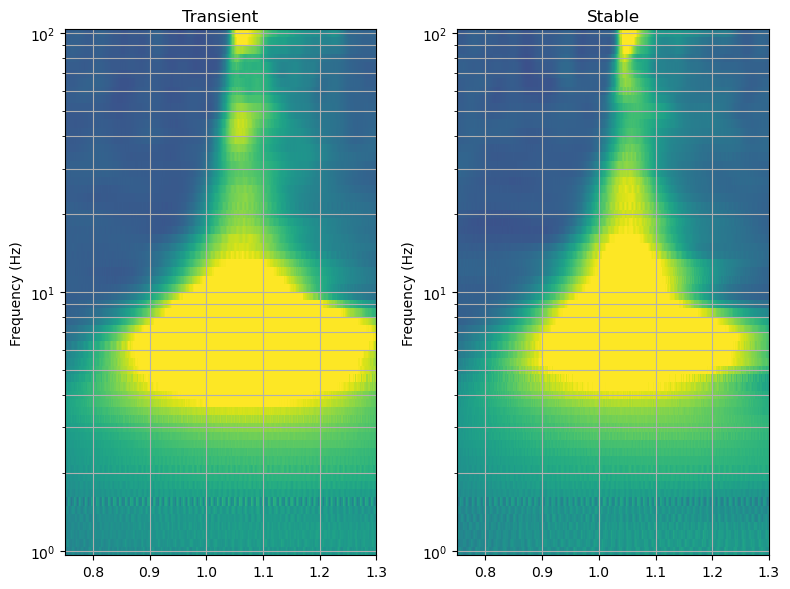

In [86]:
# transient
fpath = os.path.join(*['Y:', 'BetaGamma', 'InVitro', '24-10-25_DH36', 'Slice1', 'Cell3', '24o25007.abf'])
sweep_data,t = get_sweep_data(fpath)
spec_t = calculate_cwt(sweep_data)

# stable
fpath = os.path.join(*['Y:', 'BetaGamma', 'InVitro', '24-10-25_DH36', 'Slice1', 'Cell3', '24o25008.abf'])
sweep_data,t = get_sweep_data(fpath)
spec_s = calculate_cwt(sweep_data)

plot_spectrograms(spec_t, spec_s, t, vmin=-2, vmax=5)

### RS neuron

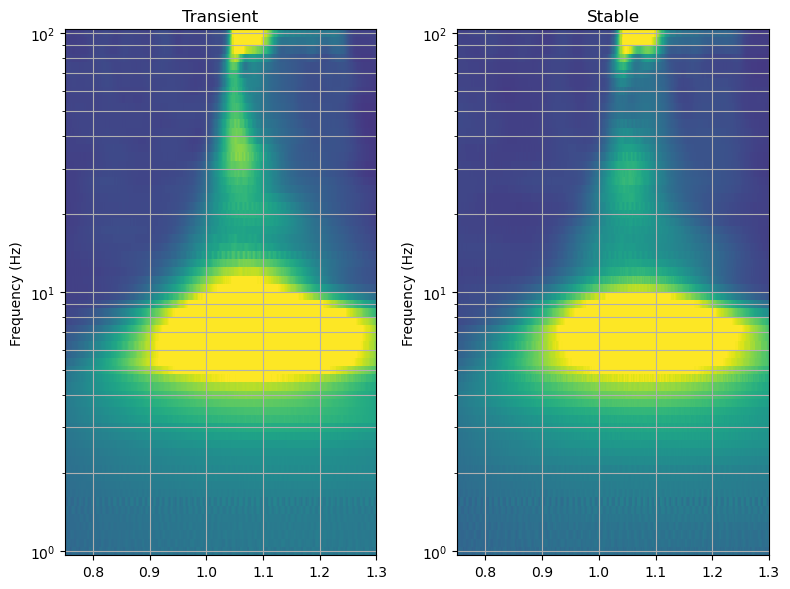

In [82]:
# transient
fpath = os.path.join(*['Y:', 'BetaGamma', 'InVitro', '24-10-25_DH36', 'Slice1', 'Cell4', '24o25012.abf'])
sweep_data,t = get_sweep_data(fpath)
spec_t = calculate_cwt(sweep_data)

# stable
fpath = os.path.join(*['Y:', 'BetaGamma', 'InVitro', '24-10-25_DH36', 'Slice1', 'Cell4', '24o25013.abf'])
sweep_data,t = get_sweep_data(fpath)
spec_s = calculate_cwt(sweep_data)

plot_spectrograms(spec_t, spec_s, t, vmin=-2, vmax=8)
